
Dataset:-


         V1        V2        V3  Amount  Time  Class
0 -1.359807 -0.072781  2.536347  149.62   0.0      0
1  1.191857  0.266151  0.166480    2.69   0.0      0
2 -1.358354 -1.340163  1.773209  378.66   1.0      0
3 -0.966272 -0.185226  1.792993  123.50   1.0      0
4 -1.158233  0.877737  1.548718   69.99   2.0      0

Dataset shape: 284807 rows × 31 columns




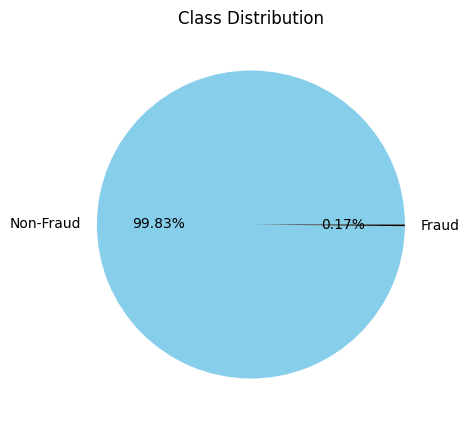


^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Logistic Regression Evaluation
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Training Time: 0.01 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91        84
           1       0.98      0.88      0.93       113

    accuracy                           0.92       197
   macro avg       0.92      0.93      0.92       197
weighted avg       0.93      0.92      0.92       197


Confusion Matrix:
 [[82  2]
 [14 99]]

Accuracy: 91.88%

AUC Score: 0.93




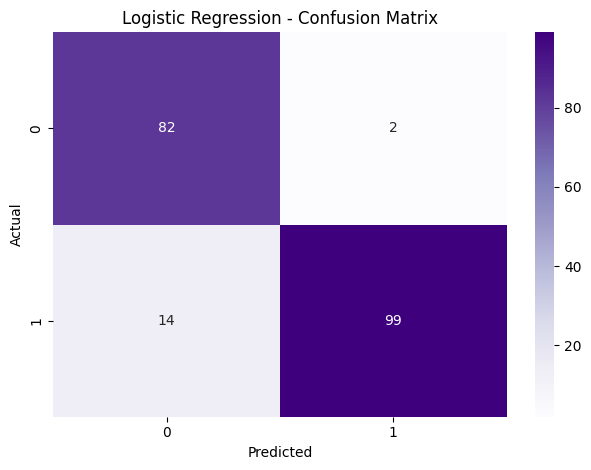


Performing Hyperparameter Tuning on Random Forest:

Best RF Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Random Forest (Tuned) Evaluation
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Training Time: 0.41 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92        84
           1       0.97      0.89      0.93       113

    accuracy                           0.92       197
   macro avg       0.92      0.93      0.92       197
weighted avg       0.93      0.92      0.92       197


Confusion Matrix:
 [[ 81   3]
 [ 12 101]]

Accuracy: 92.39%

AUC Score: 0.93




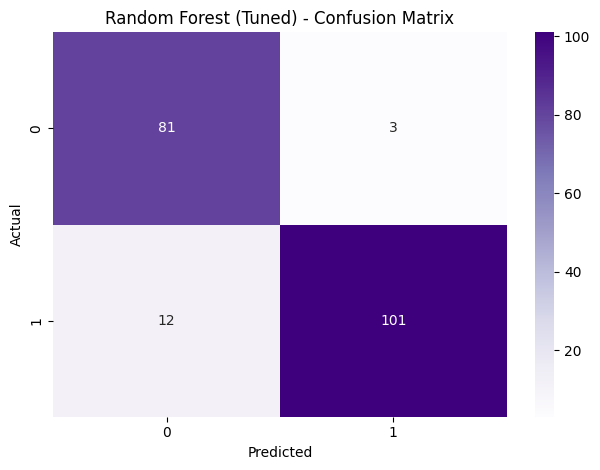

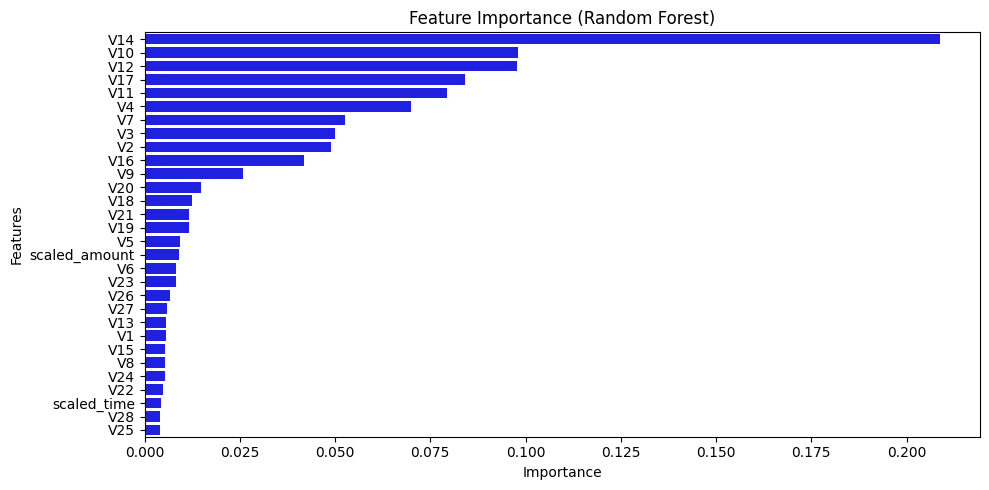

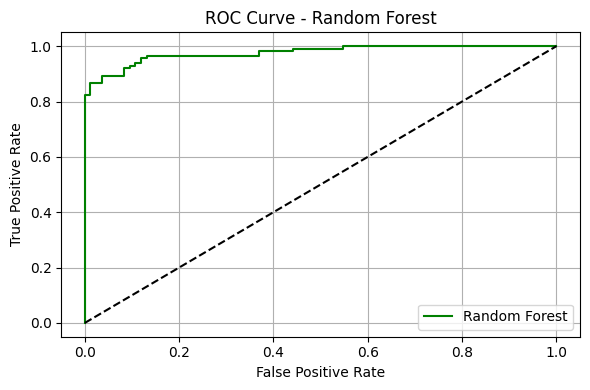

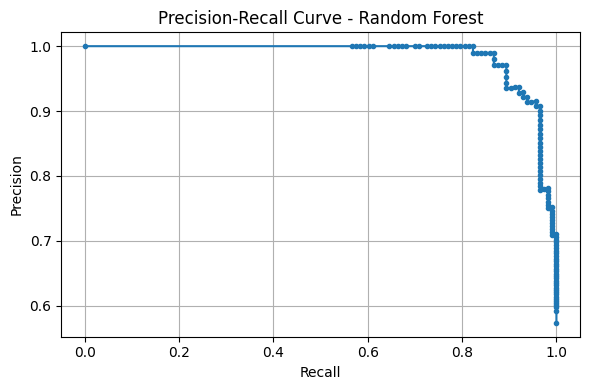




📊 Model Comparison Summary:

╒═══════════════════════╤════════════════╤═════════════╕
│ Model Name            │   Accuracy (%) │   AUC Score │
╞═══════════════════════╪════════════════╪═════════════╡
│ Logistic Regression   │       0.918782 │    0.926148 │
├───────────────────────┼────────────────┼─────────────┤
│ Random Forest (Tuned) │       0.923858 │    0.929046 │
╘═══════════════════════╧════════════════╧═════════════╛


In [9]:
# Credit Card Fraud Detection using Machine Learning

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from tabulate import tabulate
import joblib

# Step 1: Load dataset
print("\nDataset:-\n\n")
df = pd.read_csv('creditcard.csv')
print(df[['V1', 'V2', 'V3', 'Amount', 'Time', 'Class']].head())
print(f"\nDataset shape: {df.shape[0]} rows × {df.shape[1]} columns")


# Step 2: EDA - Class distribution pie chart
print( "="*150)
print("\n")
plt.figure(figsize=(5, 5))
df['Class'].value_counts().plot.pie(labels=['Non-Fraud', 'Fraud'],
                                     autopct='%1.2f%%', colors=['skyblue', 'black'])
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

# Step 3: Preprocessing
print("="*150)
rbs = RobustScaler()
scaled = rbs.fit_transform(df[['Time', 'Amount']])
scaled_df = pd.DataFrame(scaled, columns=['scaled_time', 'scaled_amount'])
df = pd.concat([df, scaled_df], axis=1)
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Step 4: Handle Imbalance
non_fraud = df[df['Class'] == 0].sample(n=492, random_state=1)
fraud = df[df['Class'] == 1]
new_df = pd.concat([non_fraud, fraud])
new_df = shuffle(new_df, random_state=2)

# Step 5: Train-test split
X = new_df.drop('Class', axis=1)
y = new_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Evaluation Function
def evaluate_model(model, name):
    print("\n" + "^"*40)
    print(f"{name} Evaluation")
    print("^"*40)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    pred = model.predict(X_test)

    print(f"Training Time: {end - start:.2f} seconds")
    print("\nClassification Report:\n", classification_report(y_test, pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))
    print("\n"f"Accuracy: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("\n"f"AUC Score: {roc_auc_score(y_test, pred):.2f}")
    print("\n")

    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt="d", cmap="Purples")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return model, pred

# Step 7: Logistic Regression
lr_model, lr_pred = evaluate_model(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    "Logistic Regression"
)

# Step 8: Random Forest + Hyperparameter Tuning
print("="*150)
print("\nPerforming Hyperparameter Tuning on Random Forest:\n")
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best RF Parameters:", grid.best_params_)

best_rf = grid.best_estimator_
rf_model, rf_pred = evaluate_model(best_rf, "Random Forest (Tuned)")

# Step 9: Feature Importance
print( "="*150)
print("\n")
importances = best_rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=features[indices], color='blue')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Step 10: ROC Curve
print("="*150)
print("\n")
rf_probs = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Random Forest', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 11: Precision-Recall Curve
print("="*90)
print("\n")
precision, recall, _ = precision_recall_curve(y_test, rf_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12: Summary Table
print("="*90)
print("\n")
results = {
    "Model Name": ["Logistic Regression", "Random Forest (Tuned)"],
    "Accuracy (%)": [accuracy_score(y_test, lr_pred), accuracy_score(y_test, rf_pred)],
    "AUC Score": [roc_auc_score(y_test, lr_pred), roc_auc_score(y_test, rf_pred)]
}
summary_df = pd.DataFrame(results)

summary_df.columns = [
    "\033[1mModel Name\033[0m",
    "\033[1mAccuracy (%)\033[0m",
    "\033[1mAUC Score\033[0m"
]

print("\n\U0001F4CA Model Comparison Summary:\n")
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))

